In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

2026-01-06 13:48:46.433686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767707326.590631      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767707326.635350      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767707327.004937      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767707327.004973      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767707327.004976      55 computation_placer.cc:177] computation placer alr

TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os

# Chemin du dataset
dataset_dir = '/kaggle/input/sneackscanv2/dataset'

print(f"dataset_dir = {dataset_dir}")
print("\nClasses trouvées :")
classes = []
for item in os.listdir(dataset_dir):
    p = os.path.join(dataset_dir, item)
    if os.path.isdir(p):
        classes.append(item)
        count = len([f for f in os.listdir(p)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f" - {item:25} {count} images")

print(f"\nTotal classes: {len(classes)}")

dataset_dir = /kaggle/input/sneackscanv2/dataset

Classes trouvées :
 - new_balance_2002r         150 images
 - asics_gel-kayano          150 images
 - nike_p6000                150 images
 - new_balance_530           150 images
 - asics_gel-nyc             150 images
 - nike_dunk_low             150 images
 - jordan_4                  150 images
 - adidas_forum_low          150 images
 - new_balance_550           150 images
 - adidas_spezial            150 images

Total classes: 10


In [3]:
# Lister toutes les classes
dataset_dir = '/kaggle/input/sneackscanv2/dataset'
classes = sorted([d for d in os.listdir(dataset_dir)
                  if os.path.isdir(os.path.join(dataset_dir, d))])

print(f"✅ {len(classes)} classes détectées:\n")
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    count = len([f for f in os.listdir(cls_path)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"   {cls:30} {count} images")

✅ 10 classes détectées:

   adidas_forum_low               150 images
   adidas_spezial                 150 images
   asics_gel-kayano               150 images
   asics_gel-nyc                  150 images
   jordan_4                       150 images
   new_balance_2002r              150 images
   new_balance_530                150 images
   new_balance_550                150 images
   nike_dunk_low                  150 images
   nike_p6000                     150 images


In [4]:
!pip install -q tensorflowjs
print("✅ Dépendances installées")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
google-colab 1.0.0 requires jupyter-server==2.14.0, but you have jupyter-server 2.12.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
xarray 2025.10.1 requires packaging>=24.1, but you have packaging 23.2 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
gradio 5.49.1 requires pydantic<2.12,>=2.0, but y

In [5]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from datetime import datetime
import json

# Configuration
DATASET_DIR = dataset_dir
OUTPUT_DIR = "/kaggle/working/trained_model"
TFJS_DIR = "/kaggle/working/tfjs_model"

# Hyperparamètres ORIGINAUX (73% accuracy)
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

CLASSES = sorted([d for d in os.listdir(DATASET_DIR)
                  if os.path.isdir(os.path.join(DATASET_DIR, d))])

print(f"📊 Configuration ORIGINALE (73%):")
print(f"   - Classes: {len(CLASSES)}")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Learning rate: {LEARNING_RATE}")

📊 Configuration ORIGINALE (73%):
   - Classes: 10
   - Batch size: 32
   - Epochs: 50
   - Learning rate: 0.001


In [6]:
print("\n" + "="*70)
print("📊 CRÉATION DES GÉNÉRATEURS")
print("="*70)

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

val_datagen = ImageDataGenerator(validation_split=VALIDATION_SPLIT)

train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='validation',
    shuffle=False
)

print(f"\n✅ Training samples:   {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")


📊 CRÉATION DES GÉNÉRATEURS
Found 1200 images belonging to 10 classes.
Found 300 images belonging to 10 classes.

✅ Training samples:   1200
✅ Validation samples: 300


In [7]:
print("\n" + "="*70)
print("🏗️  CONSTRUCTION DU MODÈLE")
print("="*70)

base_model = MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    layers.Rescaling(1./127.5, offset=-1, input_shape=(*IMG_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

print(f"\n✅ Modèle créé: {model.count_params():,} paramètres")
print(f"   Base gelée: {base_model.count_params():,} paramètres")

os.makedirs(OUTPUT_DIR, exist_ok=True)


🏗️  CONSTRUCTION DU MODÈLE


I0000 00:00:1767707344.605403      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

✅ Modèle créé: 2,423,242 paramètres
   Base gelée: 2,257,984 paramètres


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
print("\n" + "="*70)
print("🚀 ENTRAÎNEMENT PHASE 1")
print("="*70)

callbacks_phase1 = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, 'best_model_phase1.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks_phase1,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



🚀 ENTRAÎNEMENT PHASE 1
Epoch 1/50


I0000 00:00:1767707355.012646     142 service.cc:152] XLA service 0x7ccd2c110b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1767707355.012683     142 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1767707356.128799     142 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1767707362.412990     142 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.1480 - loss: 2.4765 - top_3_accuracy: 0.3849
Epoch 1: val_accuracy improved from -inf to 0.36667, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.1512 - loss: 2.4639 - top_3_accuracy: 0.3902 - val_accuracy: 0.3667 - val_loss: 1.8277 - val_top_3_accuracy: 0.6867 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - accuracy: 0.3714 - loss: 1.7284 - top_3_accuracy: 0.7311
Epoch 2: val_accuracy improved from 0.36667 to 0.49000, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 638ms/step - accuracy: 0.3726 - loss: 1.7262 - top_3_accuracy: 0.7317 - val_accuracy: 0.4900 - val_loss: 1.5122 - val_top_3_accuracy: 0.7833 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.4948 - loss: 1.4198 - top_3_accuracy: 0.8241
Epoch 3: val_accuracy improved from 0.49000 to 0.56333, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 648ms/step - accuracy: 0.4950 - loss: 1.4195 - top_3_accuracy: 0.8242 - val_accuracy: 0.5633 - val_loss: 1.2959 - val_top_3_accuracy: 0.8133 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.5932 - loss: 1.2267 - top_3_accuracy: 0.8496
Epoch 4: val_accuracy improved from 0.56333 to 0.57333, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 637ms/step - accuracy: 0.5930 - loss: 1.2268 - top_3_accuracy: 0.8498 - val_accuracy: 0.5733 - val_loss: 1.2548 - val_top_3_accuracy: 0.8467 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.6117 - loss: 1.1290 - top_3_accuracy: 0.8553
Epoch 5: val_accuracy improved from 0.57333 to 0.60000, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 629ms/step - accuracy: 0.6121 - loss: 1.1282 - top_3_accuracy: 0.8558 - val_accuracy: 0.6000 - val_loss: 1.1309 - val_top_3_accuracy: 0.8467 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.6592 - loss: 1.0089 - top_3_accuracy: 0.9048
Epoch 6: val_accuracy did not improve from 0.60000
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 625ms/step - accuracy: 0.6584 - loss: 1.0104 - top_3_accuracy: 0.9044 - val_accuracy: 0.5633 - val_loss: 1.1613 - val_top_3_accuracy: 0.8667 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.6478 - loss: 1.0187 - top_3_accuracy: 0.9043
Epoch 7: val_accuracy improved from 0.60000 to 0.65000, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 631ms/step - accuracy: 0.6478 - loss: 1.0186 - top_3_accuracy: 0.9042 - val_accuracy: 0.6500 - val_loss: 1.0277 - val_top_3_accuracy: 0.8900 - learning_rate: 0.0010
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6886 - loss: 0.9172 - top_3_accuracy: 0.9211
Epoch 8: val_accuracy improved from 0.65000 to 0.66333, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 632ms/step - accuracy: 0.6884 - loss: 0.9177 - top_3_accuracy: 0.9212 - val_accuracy: 0.6633 - val_loss: 1.0248 - val_top_3_accuracy: 0.8833 - learning_rate: 0.0010
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.7044 - loss: 0.8291 - top_3_accuracy: 0.9417
Epoch 9: val_accuracy did not improve from 0.66333
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 624ms/step - accuracy: 0.7042 - loss: 0.8296 - top_3_accuracy: 0.9417 - val_accuracy: 0.6633 - val_loss: 0.9817 - val_top_3_accuracy: 0.8933 - learning_rate: 0.0010
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - accuracy: 0.6880 - loss: 0.8590 - top_3_accuracy: 0.9349
Epoch 10: val_accuracy did not improve from 0.66333
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 624ms/step - accuracy: 0.6883 - loss: 0.8592 - top_3_accuracy: 0.9349 - val_accuracy: 0.6467 - val_loss: 0.9771 - val_top_3_accuracy: 0.9133 - learning_rate: 0.0010
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.7214 - loss: 0.8123

38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 624ms/step - accuracy: 0.7167 - loss: 0.7815 - top_3_accuracy: 0.9430 - val_accuracy: 0.6733 - val_loss: 0.9372 - val_top_3_accuracy: 0.8933 - learning_rate: 0.0010
Epoch 13/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7430 - loss: 0.7621 - top_3_accuracy: 0.9307
Epoch 13: val_accuracy did not improve from 0.67333
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 618ms/step - accuracy: 0.7428 - loss: 0.7620 - top_3_accuracy: 0.9307 - val_accuracy: 0.6567 - val_loss: 0.9446 - val_top_3_accuracy: 0.9033 - learning_rate: 0.0010
Epoch 14/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.7574 - loss: 0.6839 - top_3_accuracy: 0.9536
Epoch 14: val_accuracy did not improve from 0.67333
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 619ms/step - accuracy: 0.7575 - loss: 0.6844 - top_3_accuracy: 0.9536 - val_accuracy: 0.6400 - val_loss: 0.9896 - val_top_3_accuracy: 0.8967 - learning_rate: 0.0010
Epoch 15/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.7678 - loss: 0.67

38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 622ms/step - accuracy: 0.7643 - loss: 0.6362 - top_3_accuracy: 0.9619 - val_accuracy: 0.7000 - val_loss: 0.8982 - val_top_3_accuracy: 0.9033 - learning_rate: 0.0010
Epoch 19/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8024 - loss: 0.6309 - top_3_accuracy: 0.9539
Epoch 19: val_accuracy did not improve from 0.70000
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 618ms/step - accuracy: 0.8020 - loss: 0.6303 - top_3_accuracy: 0.9541 - val_accuracy: 0.6600 - val_loss: 0.9539 - val_top_3_accuracy: 0.9033 - learning_rate: 0.0010
Epoch 20/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.7889 - loss: 0.6177 - top_3_accuracy: 0.9632
Epoch 20: val_accuracy improved from 0.70000 to 0.70333, saving model to /kaggle/working/trained_model/best_model_phase1.h5


38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 623ms/step - accuracy: 0.7888 - loss: 0.6176 - top_3_accuracy: 0.9632 - val_accuracy: 0.7033 - val_loss: 0.8952 - val_top_3_accuracy: 0.9100 - learning_rate: 0.0010
Epoch 21/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.7993 - loss: 0.6164 - top_3_accuracy: 0.9582
Epoch 21: val_accuracy did not improve from 0.70333
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 619ms/step - accuracy: 0.7989 - loss: 0.6168 - top_3_accuracy: 0.9583 - val_accuracy: 0.6367 - val_loss: 1.0393 - val_top_3_accuracy: 0.9067 - learning_rate: 0.0010
Epoch 22/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 538ms/step - accuracy: 0.7901 - loss: 0.5938 - top_3_accuracy: 0.9617
Epoch 22: val_accuracy did not improve from 0.70333
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 614ms/step - accuracy: 0.7906 - loss: 0.5932 - top_3_accuracy: 0.9619 - val_accuracy: 0.6967 - val_loss: 0.8880 - val_top_3_accuracy: 0.9033 - learning_rate: 0.0010
Epoch 23/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.7808 - loss: 0.60

In [9]:
print("\n" + "="*70)
print("🔧 FINE-TUNING PHASE 2 - Dernières couches")
print("="*70)

base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

print(f"Couches dégelées: {sum(1 for l in base_model.layers if l.trainable)}")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy', keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

callbacks_phase2 = [
    keras.callbacks.ModelCheckpoint(
        os.path.join(OUTPUT_DIR, 'best_model_finetuned.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
]

history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    initial_epoch=len(history1.history['loss']),
    callbacks=callbacks_phase2,
    verbose=1
)

for key in history2.history:
    if key in history1.history:
        history1.history[key].extend(history2.history[key])

print("\n✅ Entraînement terminé !")


🔧 FINE-TUNING PHASE 2 - Dernières couches
Couches dégelées: 30

✅ Entraînement terminé !


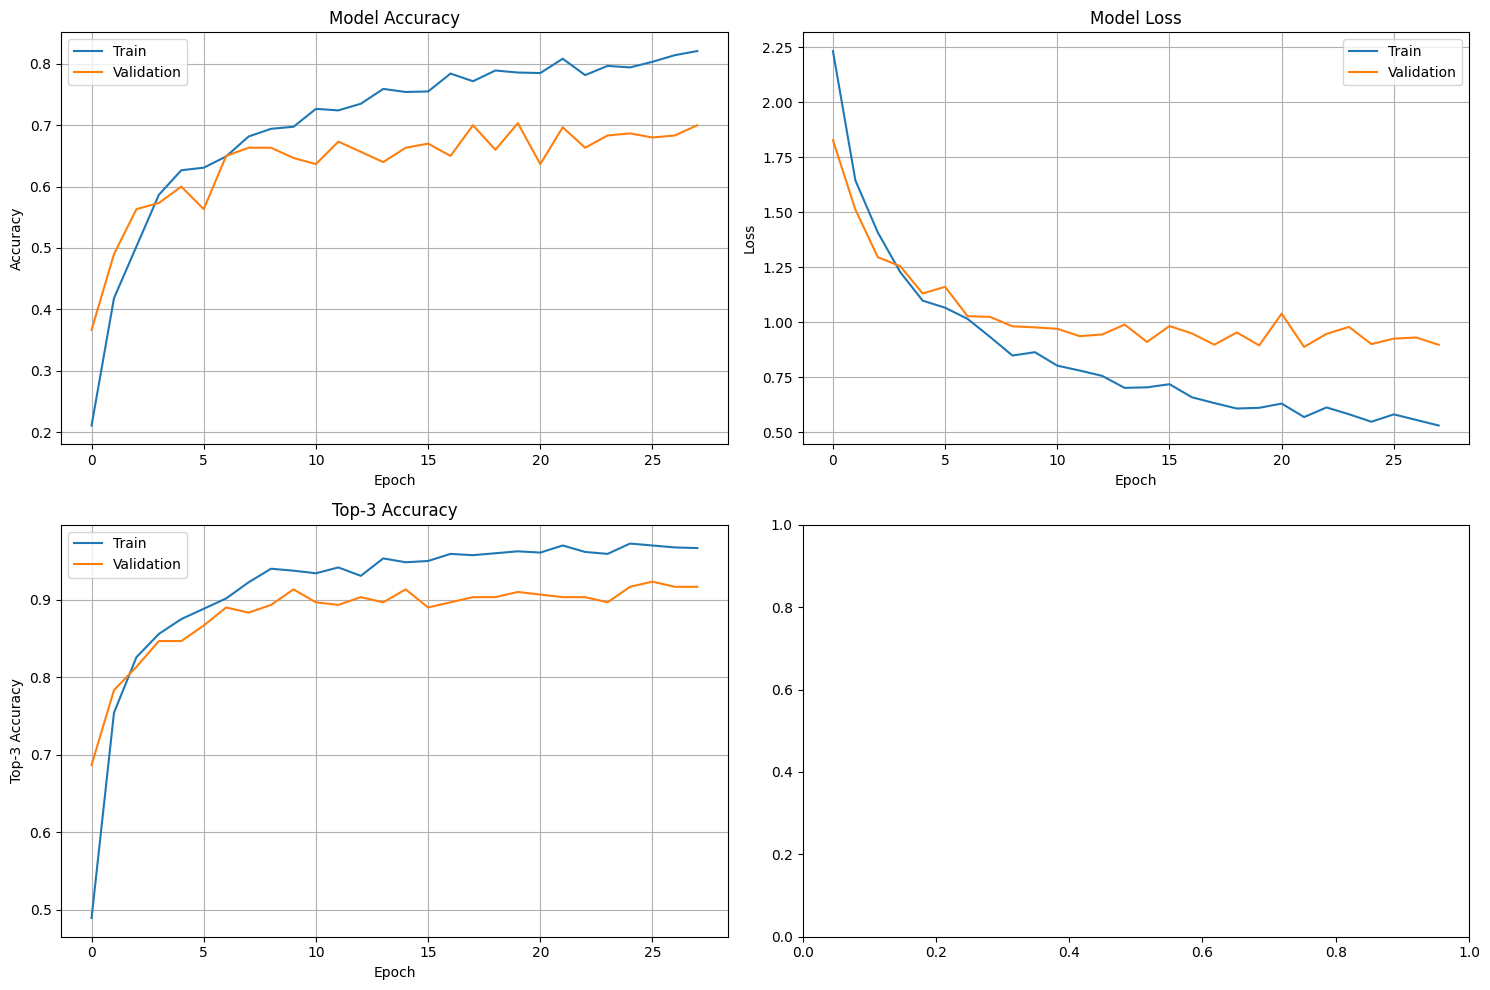

✅ Graphiques sauvegardés


In [10]:
# Graphiques d'entraînement
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history1.history['accuracy'], label='Train')
axes[0, 0].plot(history1.history['val_accuracy'], label='Validation')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history1.history['loss'], label='Train')
axes[0, 1].plot(history1.history['val_loss'], label='Validation')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot(history1.history['top_3_accuracy'], label='Train')
axes[1, 0].plot(history1.history['val_top_3_accuracy'], label='Validation')
axes[1, 0].set_title('Top-3 Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Top-3 Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=300)
plt.show()

print("✅ Graphiques sauvegardés")

In [11]:
print("\n" + "="*70)
print("📊 ÉVALUATION FINALE")
print("="*70)

results = model.evaluate(val_generator, verbose=0)

print(f"Loss:           {results[0]:.4f}")
print(f"Accuracy:       {results[1]*100:.2f}%")
print(f"Top-3 Accuracy: {results[2]*100:.2f}%")


📊 ÉVALUATION FINALE
Loss:           0.8952
Accuracy:       70.33%
Top-3 Accuracy: 91.00%


In [12]:
# Cellule 2 : Export du modèle finetuné en TF.js graph-model
import os, shutil, tensorflow as tf, tensorflowjs as tfjs

TFJS_DIR = "/kaggle/working/sneaker_model_tfjs"
SAVED_MODEL_DIR = "/kaggle/working/saved_model_export"

print("\n" + "="*70)
print("📦 EXPORT TENSORFLOW.JS (GRAPH-MODEL)")
print("="*70)

# 1) Charger le checkpoint finetuné
best_ckpt = "/kaggle/working/trained_model/best_model_finetuned.h5"
model = tf.keras.models.load_model(best_ckpt)
print(f"✅ Modèle chargé depuis : {best_ckpt}")

# 2) Exporter en SavedModel
shutil.rmtree(SAVED_MODEL_DIR, ignore_errors=True)
model.export(SAVED_MODEL_DIR)
print(f"✅ SavedModel créé : {SAVED_MODEL_DIR}")

# 3) Convertir en TF.js graph-model
shutil.rmtree(TFJS_DIR, ignore_errors=True)
tfjs.converters.convert_tf_saved_model(
    SAVED_MODEL_DIR,
    TFJS_DIR,
    strip_debug_ops=True,
)
print(f"✅ Graph-model exporté dans : {TFJS_DIR}")
print("Fichiers générés :", os.listdir(TFJS_DIR))


📦 EXPORT TENSORFLOW.JS (GRAPH-MODEL)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/trained_model/best_model_finetuned.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
print("\n" + "="*70)
print("📝 CODE POUR CameraClassifier.js")
print("="*70)

print("\nRemplace OUTPUT_CLASSES par:\n")
print("const OUTPUT_CLASSES = {")
for i, cls in enumerate(CLASSES):
    print(f'  {i}: "{cls}",')
print("};")

with open(os.path.join(OUTPUT_DIR, 'output_classes.js'), 'w') as f:
    f.write("const OUTPUT_CLASSES = {\n")
    for i, cls in enumerate(CLASSES):
        f.write(f'  {i}: "{cls}",\n')
    f.write("};\n\nexport default OUTPUT_CLASSES;\n")

print("\n✅ Code sauvegardé")

In [ ]:
# Cellule 3 : Créer le ZIP pour téléchargement
import shutil

print("📦 Création du ZIP...")
shutil.make_archive('/kaggle/working/sneaker_model3_tfjs', 'zip', TFJS_DIR)
print("✅ ZIP créé : /kaggle/working/sneaker_model3_tfjs.zip")
print("\n📁 Télécharge-le, extrais-le, et remplace model.json + group1-shard*.bin dans assets/model/")